##### 爬取cpi指数数据

In [13]:
import requests
import pandas as pd

#请求国家统计局数据
url = "https://data.stats.gov.cn/easyquery.htm"
params = {
    "m": "QueryData",                          # 查询数据
    "dbcode": "fsyd",                          # 分省月度数据库
    "rowcode": "reg",                          # 行维度：地区代码
    "colcode": "sj",                           # 列维度：时间
    "wds": '[{"wdcode":"zb","valuecode":"A01010101"}]',   # 指标：CPI 总指数
    "dfwds": '[{"wdcode":"sj","valuecode":"2020"}]',       # 过滤：2020 年
    "k1": "1764161775259"                      # 时间戳，防缓存
}


r = requests.get(url, params=params)
data = r.json()

nodes = data["returndata"]["datanodes"]

rows = []
for node in nodes:
    reg = [w for w in node["wds"] if w["wdcode"] == "reg"][0]["valuecode"]
    sj  = [w for w in node["wds"] if w["wdcode"] == "sj"][0]["valuecode"]
    month = f"{sj[:4]}-{sj[4:]}"
    val = node["data"]["strdata"]

    rows.append([reg, month, float(val)])

df = pd.DataFrame(rows, columns=["reg_code", "month", "value"])

df.head()

,reg_code,month,value
0,110000,2020-12,100.2
1,110000,2020-11,100.2
2,110000,2020-10,100.9
3,110000,2020-09,101.0
4,110000,2020-08,100.9


##### 映射行政区名

In [14]:

#添加省份名称
province_map = {
    "110000": "北京", "120000": "天津", "130000": "河北", "140000": "山西",
    "150000": "内蒙古", "210000": "辽宁", "220000": "吉林", "230000": "黑龙江",
    "310000": "上海", "320000": "江苏", "330000": "浙江", "340000": "安徽",
    "350000": "福建", "360000": "江西", "370000": "山东", "410000": "河南",
    "420000": "湖北", "430000": "湖南", "440000": "广东", "450000": "广西",
    "460000": "海南", "500000": "重庆", "510000": "四川", "520000": "贵州",
    "530000": "云南", "540000": "西藏", "610000": "陕西", "620000": "甘肃",
    "630000": "青海", "640000": "宁夏", "650000": "新疆"
}

df["province"] = df["reg_code"].map(province_map)

wide = df.pivot(index="reg_code", columns="month", values="value")

# 列名排序
month_cols = sorted(wide.columns)
wide = wide[month_cols]

# 取消 columns 的名字（就是你看到的 month）
wide.columns.name = None

# 恢复 index
wide = wide.reset_index()

# 插入省份名
wide.insert(1, "province", wide["reg_code"].map(province_map))

wide.head()


,reg_code,province,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,110000,北京,104.5,103.6,103.2,102.4,101.9,101.4,100.7,100.9,101.0,100.9,100.2,100.2
1,120000,天津,104.6,103.8,103.5,102.6,102.2,102.2,102.2,102.1,101.5,100.5,99.6,99.8
2,130000,河北,105.1,104.7,103.8,102.6,101.7,102.1,102.3,102.5,101.8,100.2,99.1,99.8
3,140000,山西,105.5,105.2,104.3,103.3,102.9,103.3,103.2,103.2,102.2,100.8,100.1,101.1
4,150000,内蒙古,104.3,103.8,103.2,102.3,101.7,101.5,101.7,101.8,101.7,100.7,99.9,100.4


##### 导出为csv表格

In [15]:
wide.to_csv('cn_cpi.csv')

##### 属性数据关联

In [16]:
# 打开shp文件
shp_path='实验数据\实验数据\cn_provinces.shp'
import geopandas as gpd
gdf = gpd.read_file(shp_path)

#输出所有字段名
gdf.columns

Index(['NAME', 'geometry'], dtype='object')

In [ ]:
#属性数据关联，将csv数据关联到cn_provinces.shp中
#cn_provinces.shp head: NAME,geometry
#csv head: reg_code,province,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
#匹配时考虑模糊匹配：
# 1）“内蒙古自治区”和“黑龙江省”截取前 3 个字符，其他地区截取前 2 个字符 
# 2) cn_cpi.csv 表中缺少数据的省份，如台湾省，取值为 100.0

gdf['province'] = gdf['NAME'].apply(lambda x: x[:3] if x.startswith('内蒙古') or x.startswith('黑龙江') else x[:2])
gdf = gdf.merge(wide, left_on='province', right_on='province', how='left')
gdf = gdf.fillna(100.0)  # 填充缺失值为 100.0
gdf.head()

,NAME,geometry,province,reg_code,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,上海市,"MULTIPOLYGON (((1545641.063 3377488.242, 15454...",上海,310000,104.3,103.0,102.8,102.5,102.0,101.7,101.6,101.4,101.3,100.3,99.9,100.1
1,云南省,"MULTIPOLYGON (((-750830.496 2515467.424, -7506...",云南,530000,106.1,106.3,105.3,104.5,103.6,103.0,103.6,104.3,103.7,102.1,100.4,100.2
2,内蒙古自治区,"POLYGON ((1137096.284 5870971.907, 1142692.852...",内蒙古,150000,104.3,103.8,103.2,102.3,101.7,101.5,101.7,101.8,101.7,100.7,99.9,100.4
3,北京市,"POLYGON ((964496.686 4466910.09, 966108.985 44...",北京,110000,104.5,103.6,103.2,102.4,101.9,101.4,100.7,100.9,101.0,100.9,100.2,100.2
4,台湾省,"MULTIPOLYGON (((1646894.656 2387882.07, 164663...",台湾,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


#### 价格指数地图可视化

C:\Users\45307\AppData\Local\Temp\ipykernel_28028\3684903759.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


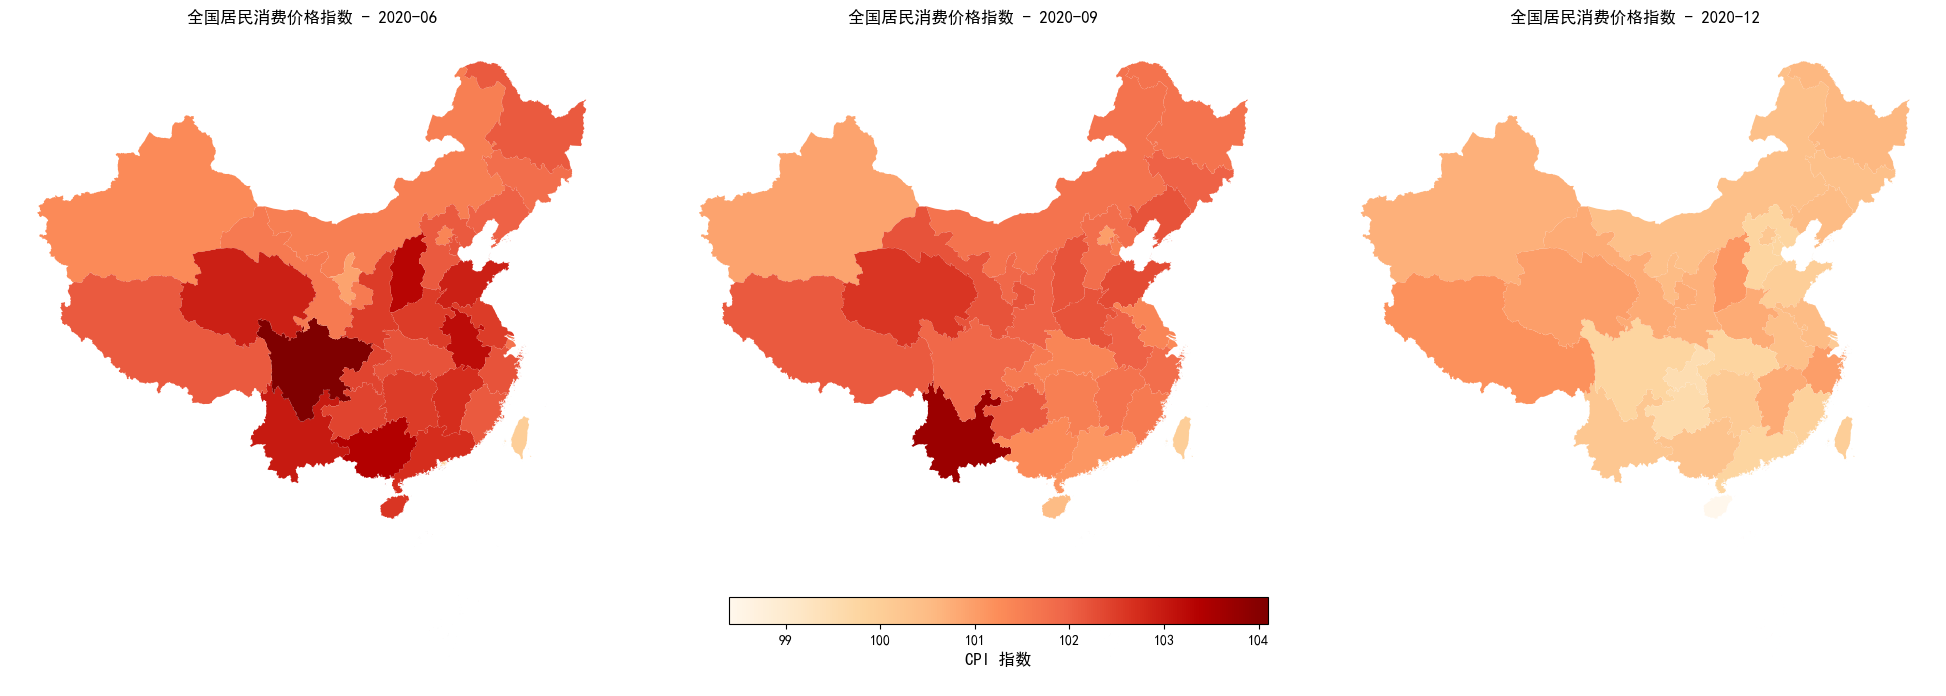

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 设置中文字体 & 修复负号问题
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 要绘制的月份
months = ['2020-06', '2020-09', '2020-12']

# 计算三个字段的全局最大最小值（确保统一色标）
all_vals = np.concatenate([gdf[m].values for m in months])
vmin, vmax = np.min(all_vals), np.max(all_vals)

# 建立大画布
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# 染色使用 OrRd
cmap = 'OrRd'

# 绘制每个子图（不生成 colorbar）
for ax, month in zip(axes, months):
    gdf.plot(column=month,
             ax=ax,
             vmin=vmin, vmax=vmax,  # 统一色标
             cmap=cmap,
             legend=False)          # ❗ 关闭各自的 colorbar

    ax.set_title(f'全国居民消费价格指数 - {month}')
    ax.set_axis_off()

# 添加一个共享 colorbar
# 用第一个子图的 mappable（利用 matplotlib.cm.ScalarMappable）
import matplotlib as mpl
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []   # 必须加，否则 colorbar 会报错

cbar = fig.colorbar(
    sm,
    ax=axes,
    orientation='horizontal',    # 横向 colorbar
    fraction=0.05,               # 控制大小
    pad=0.02                     # 与图之间的间距
)
cbar.set_label("CPI 指数", fontsize=12)

plt.tight_layout()
plt.show()


#### 价格指数统计可视化

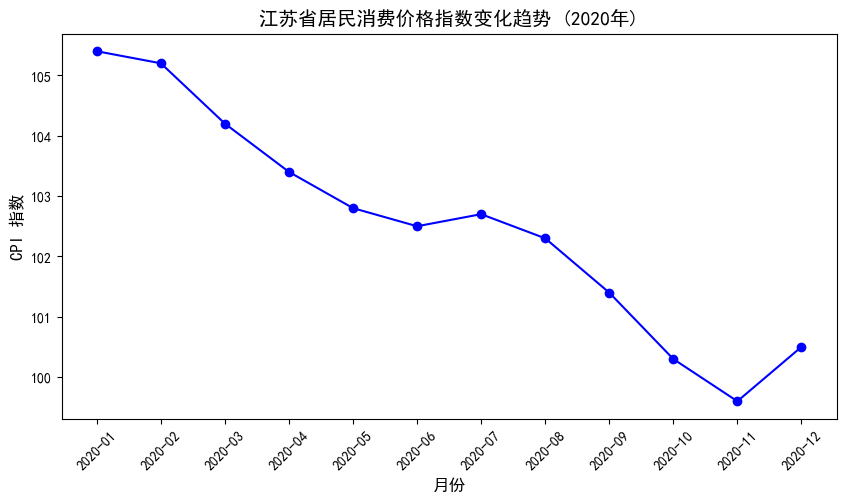

In [23]:
#展示江苏省居民消费价格指数变化趋势
js_data = df[df['province'] == '江苏'].sort_values('month')
plt.figure(figsize=(10, 5))
plt.plot(js_data['month'], js_data['value'], marker='o', color='b')
plt.title('江苏省居民消费价格指数变化趋势 (2020年)', fontsize=14)
plt.xlabel('月份', fontsize=12)
plt.ylabel('CPI 指数', fontsize=12)
plt.xticks(rotation=45)
plt.show()